# Binary Prediction of Poisonous Mushrooms

O dataset para esta competição (tanto o de treinamento quanto o de teste) foi gerado a partir de um modelo de aprendizado profundo treinado com o conjunto de dados de Cogumelos da UCI. As distribuições das variáveis são próximas, mas não exatamente iguais, às do original. Sinta-se à vontade para usar o conjunto de dados original como parte desta competição, tanto para explorar as diferenças quanto para verificar se a incorporação do original no treinamento melhora o desempenho do modelo.

## Metas e objetivos
O objetivo deste projeto é (1) encontrar o modelo que se adeque melhor a métrica de avaliação da competição (o Matthews Correlation Coefficient), e (2) após 4 submissões quero ter documentada essa tentativa da minha primeira competição no Kaggle. Meu melhor resultado foi 0.97837. 

# Preparando o ambiente
## Bibliotecas e dados

In [62]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Análise Exploratória de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import optuna 
import lightgbm as lgb
from sklearn import metrics

# Pré-processamento
from category_encoders import TargetEncoder
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Dark2')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [2]:
train_data = pd.read_csv("../data/raw/train.csv")
test_data = pd.read_csv("../data/raw/test.csv")

## Check-up dos dados

In [3]:
train_data.shape

(3116945, 22)

In [4]:
train_data.dtypes

id                        int64
class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object

In [5]:
train_data.isnull().mean().sort_values()

id                      0.000000
stem-width              0.000000
stem-height             0.000000
season                  0.000000
class                   0.000000
cap-diameter            0.000001
does-bruise-or-bleed    0.000003
cap-color               0.000004
has-ring                0.000008
stem-color              0.000012
cap-shape               0.000013
habitat                 0.000014
gill-color              0.000018
ring-type               0.041348
gill-attachment         0.168093
cap-surface             0.215282
gill-spacing            0.403740
stem-surface            0.635514
veil-color              0.879370
stem-root               0.884527
spore-print-color       0.914255
veil-type               0.948843
dtype: float64

# Preparando os dados

## Seleção das features e divisão dos dados

In [31]:
# Vou remover as colunas com mais de 50% de missing 

colunas = train_data.isnull().mean()
filtro = colunas[colunas < 0.50].index
train_data = train_data[filtro]
train_data.columns.tolist()

['id',
 'class',
 'cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-color',
 'has-ring',
 'ring-type',
 'habitat',
 'season']

In [32]:
X = train_data.drop(columns = ['id', 'class'], axis = 1)
y = train_data['class']

In [33]:
y = y.map({'e': 1, 'p': 0})

In [34]:
cat_features = X.select_dtypes(exclude = 'number').columns.to_list()
num_features = X.select_dtypes(include = 'number').columns.to_list()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=21, test_size=0.20)

## Pré-processamento

In [36]:
imputer_cat = CategoricalImputer(imputation_method='frequent')

X_train[cat_features] = imputer_cat.fit_transform(X_train[cat_features])
X_test[cat_features] = imputer_cat.transform(X_test[cat_features])

In [37]:
imputer_num = MeanMedianImputer(imputation_method='median')

X_train[num_features] = imputer_num.fit_transform(X_train[num_features])
X_test[num_features] = imputer_num.transform(X_test[num_features])

In [38]:
encoder = TargetEncoder(cols = cat_features)

X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

## Mutual Information

In [39]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train_encoded, y_train)

mi_df = pd.DataFrame({'Feature': X_train_encoded.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by = 'Mutual Information', ascending = False)
print(mi_df)

                 Feature  Mutual Information
12             ring-type            0.248026
11              has-ring            0.216191
4   does-bruise-or-bleed            0.190302
13               habitat            0.177313
6           gill-spacing            0.162138
10            stem-color            0.135740
14                season            0.124482
1              cap-shape            0.101756
3              cap-color            0.093023
5        gill-attachment            0.081449
2            cap-surface            0.080677
7             gill-color            0.080561
9             stem-width            0.067697
0           cap-diameter            0.042662
8            stem-height            0.041145


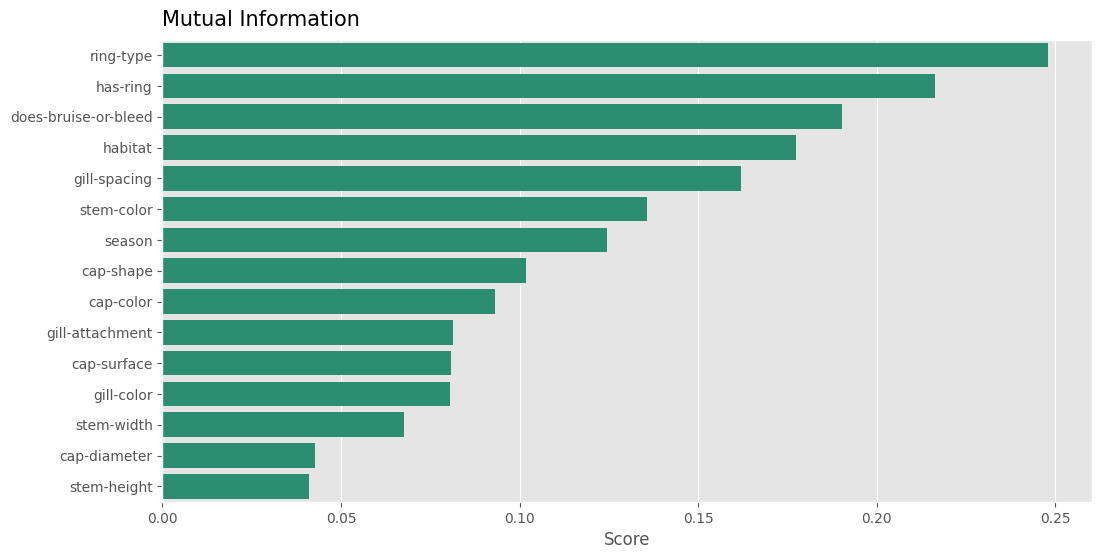

In [43]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(x = mi_df['Mutual Information'], y = mi_df['Feature'])
ax.set_title("Mutual Information", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Score")
ax.set_ylabel("")
plt.show()

Todas as features apresentam um grau positivo de informação mútua, então vamos utilizar todas no modelo.

# Modelo de classifação 

## Modelo base

In [45]:
# Pipeline de pré-processamento

cat_transformer = Pipeline([
    ('imput', CategoricalImputer(imputation_method='frequent')),
    ('encoder', TargetEncoder())
])

num_transformer = Pipeline([
    ('imput', MeanMedianImputer(imputation_method='median'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

In [88]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(verbosity = -1, random_state=21))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-color', 'has-ring',
                                                   'ring-type', 'habitat',
                                                   'season']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width'])])),
                ('model', LGBMClassifier(random_state=21, verbosity=-1))])

In [89]:
y_proba = clf.predict_proba(X_test)[:,1]
y_pred = (y_proba > 0.50).astype(int)

In [90]:
print(f"Métricas - Validação\n{"=" * 30}")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {metrics.roc_auc_score(y_test, y_proba)}")
print(f"F1 Score: {metrics.f1_score(y_test, y_pred)}")
print(f"MCC: {metrics.matthews_corrcoef(y_test, y_pred)}")

Métricas - Validação
Accuracy: 0.984966048486579
ROC AUC: 0.9954614324923325
F1 Score: 0.9834221307125725
MCC: 0.9696716375812854


In [91]:
scoring = metrics.make_scorer(metrics.matthews_corrcoef)
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=21)

scores = cross_val_score(clf, X_train, y_train, cv = cv, scoring = scoring)
print(f"Média do MCC: {scores}")
print(f"Média Geral do MCC: {scores.mean()}")
print(f"Desvio Padrão do MCC: {scores.std()}")

Média do MCC: [0.9696408  0.96868204 0.96879549 0.96972553 0.96841233]
Média Geral do MCC: 0.9690512388137936
Desvio Padrão do MCC: 0.0005314420304894653


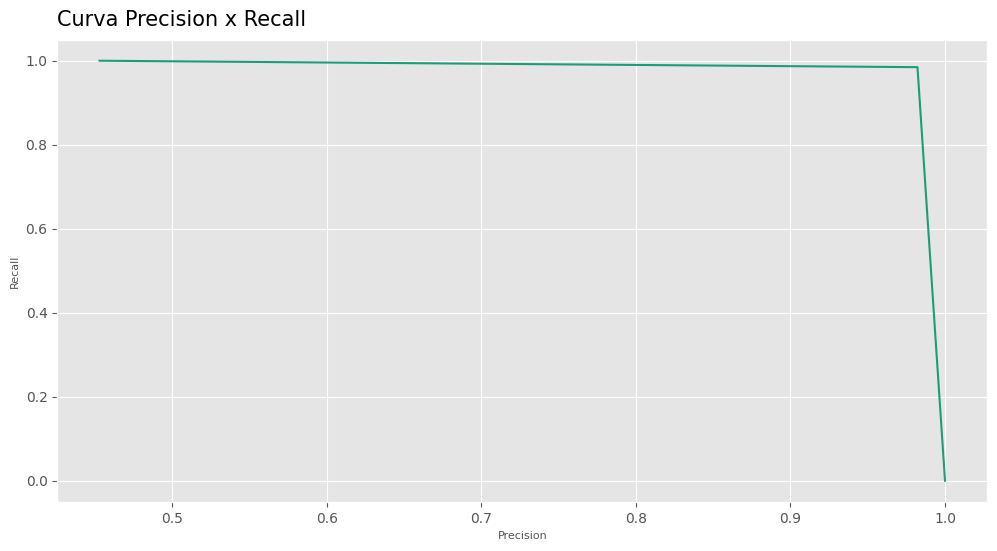

In [55]:
precision, recall, thres = metrics.precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = precision, y = recall)
ax.set_title("Curva Precision x Recall", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Precision", fontsize = 8)
ax.set_ylabel("Recall", fontsize = 8)
plt.show()


In [56]:
curva_roc = metrics.roc_curve(y_test, y_proba)

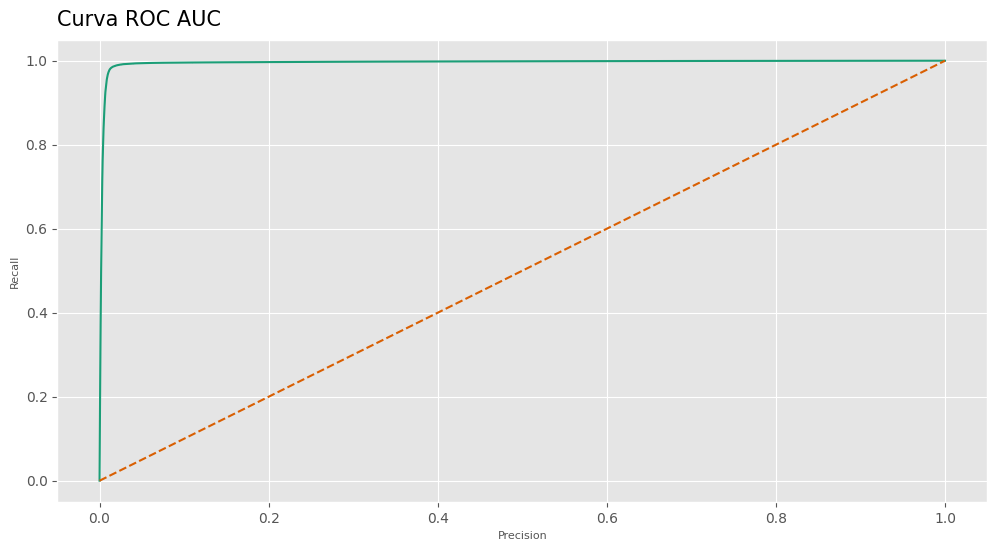

In [60]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = curva_roc[0], y = curva_roc[1])
sns.lineplot(x = [0, 1], y = [0, 1], markers = True, linestyle = '--')
ax.set_title(f"Curva ROC AUC", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Precision", fontsize = 8)
ax.set_ylabel("Recall", fontsize = 8)
plt.show()

O modelo base apresentou excelente métricas no geral e uma excelente capacidade de generalização, mas pra nossa competição precisamos ainda melhorar o MCC e o próximo passo será a otimização dos hiper-parâmetros! 

## Otimização dos Hiper-parâmetros

In [61]:
def objective(trial):
    model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        verbosity = -1,
        n_estimators = 1000,
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        num_leaves = trial.suggest_int("num_leaves", 2, 2**10),
        subsample = trial.suggest_float("subsample", 0.05, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.05, 1.0),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 100),
        random_state = 21
    ))
    ])

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mcc = metrics.matthews_corrcoef(y_test, predictions)
    return mcc

In [63]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-08-16 11:26:09,208] A new study created in memory with name: no-name-fcdd5ec6-ed36-42ec-89aa-5ea50f1460a9
[I 2024-08-16 11:30:43,295] Trial 0 finished with value: 0.8020137481560433 and parameters: {'learning_rate': 0.0019728773149599375, 'num_leaves': 709, 'subsample': 0.7894151003883515, 'colsample_bytree': 0.1383263881307738, 'min_data_in_leaf': 76}. Best is trial 0 with value: 0.8020137481560433.
[I 2024-08-16 11:34:52,550] Trial 1 finished with value: 0.9585577278259518 and parameters: {'learning_rate': 0.03826072754471737, 'num_leaves': 567, 'subsample': 0.18481771685896398, 'colsample_bytree': 0.1646142993998216, 'min_data_in_leaf': 98}. Best is trial 1 with value: 0.9585577278259518.
[I 2024-08-16 11:41:19,370] Trial 2 finished with value: 0.9823194238429301 and parameters: {'learning_rate': 0.030335067453773394, 'num_leaves': 812, 'subsample': 0.15332904102308065, 'colsample_bytree': 0.49554367610552635, 'min_data_in_leaf': 19}. Best is trial 2 with value: 0.9823194238

In [64]:
print(f"Melhores hiper-parâmetros: {study.best_params}")
print(f"Melhor MCC: {study.best_value}")

Melhores hiper-parâmetros: {'learning_rate': 0.030335067453773394, 'num_leaves': 812, 'subsample': 0.15332904102308065, 'colsample_bytree': 0.49554367610552635, 'min_data_in_leaf': 19}
Melhor MCC: 0.9823194238429301


In [65]:
best_params = study.best_params
best_params

{'learning_rate': 0.030335067453773394,
 'num_leaves': 812,
 'subsample': 0.15332904102308065,
 'colsample_bytree': 0.49554367610552635,
 'min_data_in_leaf': 19}

In [66]:
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(**study.best_params, n_estimators=1000, random_state=21))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imput',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder())]),
                                                  ['cap-shape', 'cap-surface',
                                                   'cap-color',
                                                   'does-bruise-or-bleed',
                                                   'gill-attachment',
                                                   'gill-spacing', 'gill-color',
                                                   'stem-color', 'has-ring',
                                                   'ring-type', 'habitat',
                                                   'season']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer())]),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.49554367610552635,
                                learning_rate=0.030335067453773394,
                                min_data_in_leaf=19, n_estimators=1000,
                                num_leaves=812, random_state=21,
                                subsample=0.15332904102308065))])

In [73]:
y_proba = clf.predict_proba(X_test)[:,1]
y_pred = (y_proba > 0.50).astype(int)

In [74]:
print(f"Métricas - Validação (Optuna)\n{"=" * 30}")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(f"ROC AUC: {metrics.roc_auc_score(y_test, y_proba)}")
print(f"F1 Score: {metrics.f1_score(y_test, y_pred)}")
print(f"MCC: {metrics.matthews_corrcoef(y_test, y_pred)}")

Métricas - Validação (Optuna)
Accuracy: 0.9912350073549582


ROC AUC: 0.9968762964639637
F1 Score: 0.9903350880172073
MCC: 0.9823194238429301


Conseguimos uma melhora no MCC com a tunagem dos hiper-parâmetros, agora por fim vamos buscar ajustar isso com um limiar diferente. 

In [75]:
thresholds = np.arange(0.0, 1.01, 0.01)

mccs = []

for threshold in thresholds:
    y_predict = (y_proba > threshold).astype(int)

    mcc = metrics.matthews_corrcoef(y_test, y_predict)
    mccs.append(mcc)

best_threshold = thresholds[np.argmax(mccs)]
best_mcc = max(mccs)

print(f"Melhor limiar: {best_threshold}")
print(f"Melhor MCC: {best_mcc}")

Melhor limiar: 0.45
Melhor MCC: 0.9823787995025628


In [76]:
y_pred_final = (y_proba > 0.45).astype(int)

print(f"Métricas - Validação (Optuna e Limiar 0.45)\n{"=" * 30}")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred_final)}")
print(f"ROC AUC: {metrics.roc_auc_score(y_test, y_proba)}")
print(f"F1 Score: {metrics.f1_score(y_test, y_pred_final)}")
print(f"MCC: {metrics.matthews_corrcoef(y_test, y_pred_final)}")

Métricas - Validação (Optuna e Limiar 0.45)
Accuracy: 0.9912622776468626
ROC AUC: 0.9968762964639637
F1 Score: 0.9903703192980782
MCC: 0.9823787995025628


Para finalizar a validação cruzada e visualizações. 

In [77]:
scoring = metrics.make_scorer(metrics.matthews_corrcoef)
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=21)

scores = cross_val_score(clf, X_train, y_train, cv = cv, scoring = scoring)
print(f"Média do MCC: {scores}")
print(f"Média Geral do MCC: {scores.mean()}")
print(f"Desvio Padrão do MCC: {scores.std()}")

Média do MCC: [0.98212434 0.98200328 0.98208023 0.98208087 0.98213561]
Média Geral do MCC: 0.9820848637133665
Desvio Padrão do MCC: 4.65334874908159e-05


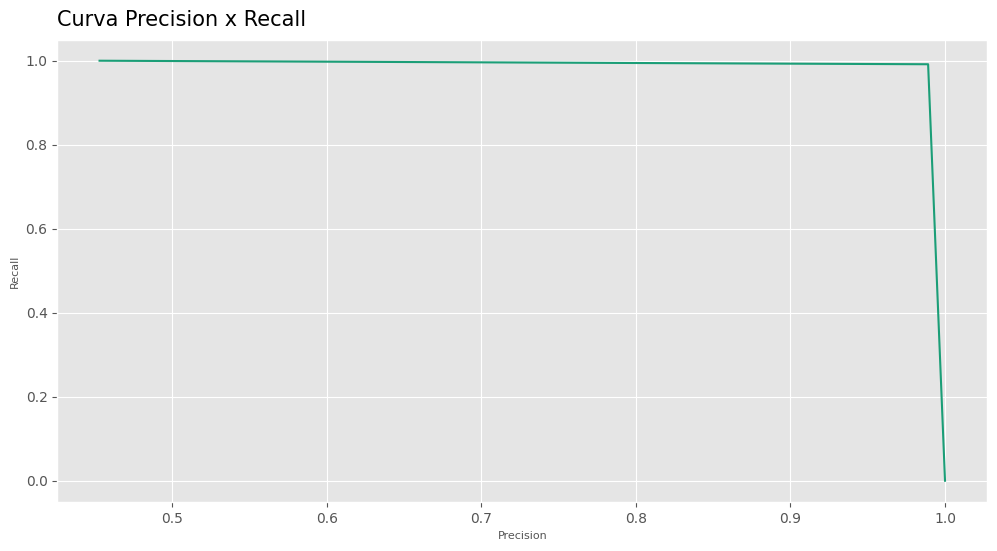

In [78]:
precision, recall, thres = metrics.precision_recall_curve(y_test, y_pred)

fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = precision, y = recall)
ax.set_title("Curva Precision x Recall", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Precision", fontsize = 8)
ax.set_ylabel("Recall", fontsize = 8)
plt.show()

In [79]:
curva_roc = metrics.roc_curve(y_test, y_proba)

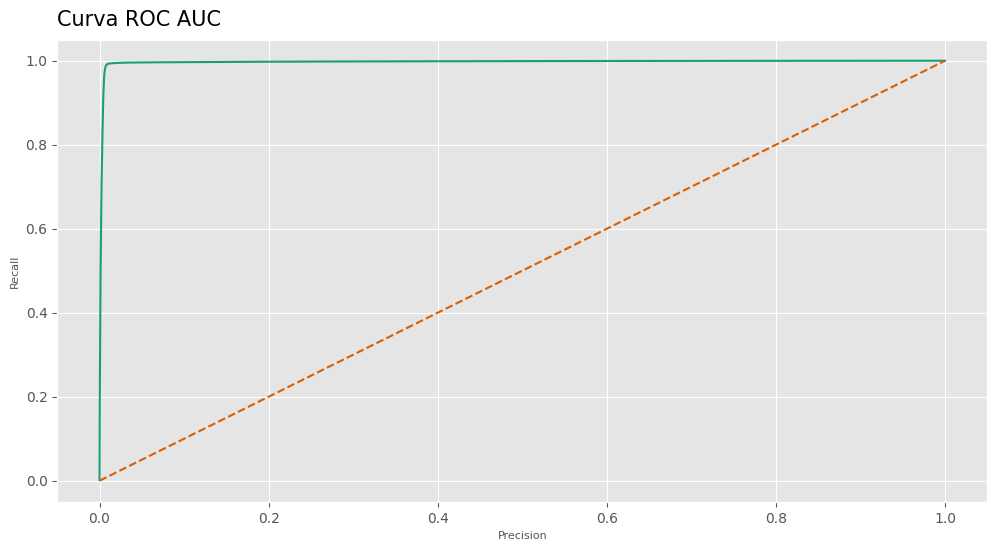

In [80]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.lineplot(x = curva_roc[0], y = curva_roc[1])
sns.lineplot(x = [0, 1], y = [0, 1], markers = True, linestyle = '--')
ax.set_title(f"Curva ROC AUC", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Precision", fontsize = 8)
ax.set_ylabel("Recall", fontsize = 8)
plt.show()

Este é o melhor resultado que consegui com meus conhecimentos atuais, preciso melhorar ainda meu feature engineering. No conjunto utilizado para treino e validação chegamos a um MCC de 0.9820848637133665 e vamos para a hora da verdade! Momento de fazer as predições utilizando os dados de teste e submeter ao Kaggle.

# Conclusão e resultados na competição

In [83]:
X = test_data[cat_features + num_features]

In [84]:
y_pred_kaggle = clf.predict(X)
test_data['class'] = y_pred_kaggle
test_data.head()

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a,1
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a,0
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s,0
3,3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u,0
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u,1


In [87]:
sub_file = test_data[['id', 'class']].copy()
sub_file['class'] = sub_file['class'].map({1: 'e', 0: 'p'})
sub_file.to_csv("../data/processed/submissionfile.csv", index = False)

![imagem](https://github.com/datalopes1/kaggle_mushrooms/blob/main/doc/img/subpic.png?raw=true)
![imagem](https://github.com/datalopes1/kaggle_mushrooms/blob/main/doc/img/ranking.png?raw=true)

Consegui melhorar em relação a meu último resultado, ainda tenho muito espaço e quesitos para melhorar. É uma boa experiência lidar com um conjunto de dados maior do que aqueles que tenho usado para praticar, além de tudo aprendi bastante no processo. 